# Import libraries and Get data

In [ ]:
#@title Import libraries
import sys
import numpy as np
import pandas as pd
import pickle
import os
import pathlib
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import cv2
import time
import numpy.random as rng
from sklearn.utils import shuffle

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate, Dropout
from keras.models import Model

from keras.layers import BatchNormalization
from keras.layers.pooling import MaxPooling2D
#from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform

from keras.layers import Layer
from keras.regularizers import l2
from keras import backend as K
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

In [ ]:
#@title Get data
!gdown 1SxiuUPNAV-rrjEjkUQdsZZuJltaal2tH
!unzip signatures_flavour.zip

# Create Data loader for model

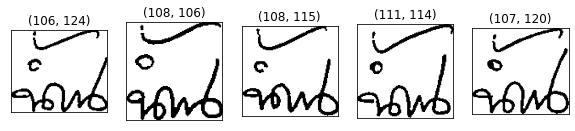

In [ ]:
#@title Explore random signer
import matplotlib.image as mpimg

data_dir = '/content/signatures_flavour'
subset_folder = 'training'

# randomly select class
rand_signer = rng.choice(os.listdir(os.path.join(data_dir, subset_folder)))
image_dir = os.path.join(data_dir, f'{subset_folder}/{rand_signer}/genuine')
image_files = os.listdir(image_dir)

# show all images within class
for i, image_file in enumerate(image_files):
    image = mpimg.imread(os.path.join(image_dir, image_file))
    if i%5 ==0: fig, axs = plt.subplots(1,5, figsize=(10,10))
    axs[i%5].get_yaxis().set_visible(False)
    axs[i%5].get_xaxis().set_visible(False)
    _ = axs[i%5].imshow(image, cmap='gray')
    _ = axs[i%5].set_title(image.shape)

In [ ]:
#@title Image Preprocessing

class Image_Preprocessing:
    def __init__(self, img_height, img_width):
        self.img_height = img_height
        self.img_width = img_width
    
    def processing(self, image):
        # Resize image -> Grayscale conversion -> Normalization
        image = cv2.resize(image, (self.img_width, self.img_height))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        image = np.array(image, dtype='float32')
        image = image / 255.0
        return image[..., np.newaxis]
    
    def imread(self, path):
        image = cv2.imread(path)
        image = self.processing(image)
        return image

img_height, img_width = 155, 220
img_pre = Image_Preprocessing(img_height, img_width)

In [ ]:
#@title Load image into dictionary of array

def load_img_arr(img_pre, path, subset_folder):
    signer_dir = os.path.join(path, subset_folder)
    img_arr_dict = {}
    signers = os.listdir(signer_dir)
    signers.sort()

    for signer in signers:
        genuine_images = []
        genuine_dir = f'{signer_dir}/{signer}/genuine'
        genuine_image_list = os.listdir(genuine_dir)
        genuine_image_list.sort()
        for genuine_image_file in genuine_image_list:
            genuine_image_path = os.path.join(genuine_dir, genuine_image_file)
            genuine_image = img_pre.imread(genuine_image_path)          
            genuine_images.append(genuine_image)
        
        forgery_images = []
        forgery_dir = f'{signer_dir}/{signer}/skilled forgery'
        forgery_image_list = os.listdir(forgery_dir)
        forgery_image_list.sort()
        for forgery_image_file in forgery_image_list:
            forgery_image_path = os.path.join(forgery_dir, forgery_image_file)
            forgery_image = img_pre.imread(forgery_image_path)          
            forgery_images.append(forgery_image)
        
        genuine_set = np.stack(genuine_images)
        forgery_set = np.stack(forgery_images)
        img_arr_dict[signer] = {'Genuine': genuine_set,
                                'Forgery': forgery_set}
    return img_arr_dict # [signer][kind][imgNo,size]

In [ ]:
#@title Data loader

class Data_Loader:
    def __init__(self, img_arr_train, img_arr_val, img_arr_test):
        self.img_arr_dict = {'train': img_arr_train,
                             'val': img_arr_val,
                             'test': img_arr_test}

    # Create batch of n pairs, half same class, half different class
    def get_batch(self, batch_size, subset='train'):
        img_arr = self.img_arr_dict[subset]

        #randomly sample several classes to use in the batch
        signers = list(img_arr.keys())
        n_signers = len(signers)
        categories = rng.choice(n_signers, size=(batch_size,), replace=False)

        #initialize 2 empty arrays for the input image batch
        n_img, img_h, img_w, img_ch = img_arr[signers[0]]['Genuine'].shape
        pairs=[np.zeros((batch_size, img_h, img_w, 1)) for i in range(2)]

        #initialize vector for the targets, and make one half of it '1's, so 2nd half of batch has same class
        targets=np.zeros((batch_size,))
        targets[batch_size//2:] = 1

        for i in range(batch_size):
            category_1 = categories[i]

            #pick images of same class for 1st half, different for 2nd
            if i >= batch_size // 2:
                category_2 = category_1
            else: 
                #add a random number to the category modulo n classes to ensure 2nd image has different category
                category_2 = (category_1 + rng.randint(1, n_signers)) % n_signers
            
            signer_1 = signers[category_1]
            signer_2 = signers[category_2]

            images_1 = img_arr[signer_1]['Genuine']
            images_2 = img_arr[signer_2]['Genuine']

            rand_idx_1 = rng.choice(len(images_1))
            rand_idx_2 = rng.choice(len(images_2))

            pairs[0][i,:,:,:] = images_1[rand_idx_1,:,:,:]
            pairs[1][i,:,:,:] = images_2[rand_idx_2,:,:,:]
        return pairs, targets
    
    # a generator for batches, so model.fit_generator can be used.
    def generate(self, batch_size, subset="train"):
        while True:
            pairs, targets = self.get_batch(batch_size, subset)
            yield (pairs, targets)

    # Create pairs of test image, support set for testing N way one-shot learning.
    def make_recognition_tasks(self, n_way, n_tasks, subset="train", shuffle_pairs=False):
        main_img_arr = self.img_arr_dict[subset]
        support_img_arr = self.img_arr_dict[subset]   
        if subset == 'test': support_img_arr = self.img_arr_dict['train']

        signers = list(main_img_arr.keys())
        tasks = []

        for i in range(n_tasks):
            # randomly sample several classes
            rand_signers = rng.choice(signers, size=(n_way,), replace=False)

            # get test image and create test set
            main_images = main_img_arr[rand_signers[0]]['Genuine']
            main_idx = rng.choice(len(main_images))
            main_image = main_images[main_idx,:,:,:]
            main_set = np.asarray([main_image]*n_way)

            # create support set
            support_set = []
            for signer in rand_signers:
                support_images = support_img_arr[signer]['Genuine']
                n_support_images = len(support_images)
                if signer == rand_signers[0] and subset != 'test':
                    support_idx = (main_idx + rng.randint(1, n_support_images)) % n_support_images
                else:
                    support_idx = rng.choice(n_support_images)
                support_image = support_images[support_idx,:,:,:]
                support_set.append(support_image)
            support_set = np.stack(support_set)

            targets = np.zeros((n_way,))
            targets[0] = 1

            if shuffle_pairs: targets, main_set, support_set = shuffle(targets, main_set, support_set)
            pairs = [main_set, support_set]
            tasks.append((pairs, targets))
        
        tasks = shuffle(tasks)
        return tasks

    # Create Genuine-Genuine and Genuine-Forged image pairs for each tasks.
    def make_verification_tasks(self, n_tasks, subset='train'):
        main_img_arr = self.img_arr_dict[subset]
        support_img_arr = self.img_arr_dict[subset]   
        if subset == 'test': support_img_arr = self.img_arr_dict['train']

        signers = list(main_img_arr.keys())
        rand_signers = rng.choice(signers, size=(n_tasks,), replace=True)

        main_set = []
        support_set = []
        targets = []

        for signer in rand_signers:
            # get test image
            main_images = main_img_arr[signer]['Genuine']
            main_idx = rng.choice(len(main_images))
            main_image = main_images[main_idx,:,:,:]

            # get genuine image
            genuine_images = support_img_arr[signer]['Genuine']
            n_genuine_images = len(genuine_images)
            if subset != 'test':
                genuine_idx = (main_idx + rng.randint(1, n_genuine_images)) % n_genuine_images 
            else:
                genuine_idx = rng.choice(n_genuine_images )
            genuine_image = genuine_images[genuine_idx,:,:,:]
            
            # create Genuine-Genuine image pairs
            main_set.append(main_image)
            support_set.append(genuine_image)
            targets.append(1)

            # get forgery image
            forgery_images = support_img_arr[signer]['Forgery']
            forgery_idx = rng.choice(len(forgery_images))
            forgery_image = forgery_images[forgery_idx,:,:,:]

            # create Genuine-Forged image pairs
            main_set.append(main_image)
            support_set.append(forgery_image)
            targets.append(0)
  
        # convert to numpy
        main_set = np.stack(main_set)
        support_set = np.stack(support_set)
        targets = np.array(targets)

        # shuffle tasks
        targets, main_set, support_set = shuffle(targets, main_set, support_set)
        pairs = [main_set, support_set]
        tasks = (pairs, targets)
        return tasks

In [ ]:
img_arr_train = load_img_arr(img_pre, data_dir, 'training')
img_arr_val = load_img_arr(img_pre, data_dir, 'validation')
img_arr_test = load_img_arr(img_pre, data_dir, 'testing')
my_loader = Data_Loader(img_arr_train, img_arr_val, img_arr_test)

# Visualizing test image and support set

## show batch and verification tasks

In [ ]:
#@title Define show pairs function
def show_pairs(pairs, targets, figsize=(4,4)):
    n, h, w, ch = pairs[0].shape

    for idx, image_pair in enumerate(zip(pairs[0], pairs[1])):
        print(f'pair   : {idx+1}')
        print(f'target : {targets[idx]}')
        fig, axs = plt.subplots(1,2, figsize=figsize)
        axs[0].get_yaxis().set_visible(False)
        axs[0].get_xaxis().set_visible(False)
        axs[1].get_yaxis().set_visible(False)
        axs[1].get_xaxis().set_visible(False)
        _ = axs[0].imshow(image_pair[0].reshape(h, w), cmap='gray')
        _ = axs[0].set_title('image 1')
        _ = axs[1].imshow(image_pair[1].reshape(h, w), cmap='gray')
        _ = axs[1].set_title('image 2')
        plt.show()

pair   : 1
target : 0.0


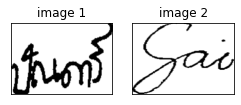

pair   : 2
target : 0.0


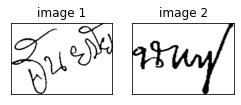

pair   : 3
target : 1.0


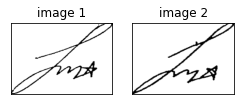

pair   : 4
target : 1.0


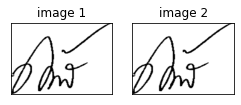

In [ ]:
#@title Visualize batch

batch_size = 4 #@param ["4", "8", "16"] {type:"raw"}
subset = "train" #@param ["train", "val"]

pairs, targets = my_loader.get_batch(batch_size, subset)
show_pairs(pairs, targets)

pair   : 1
target : 0


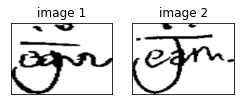

pair   : 2
target : 0


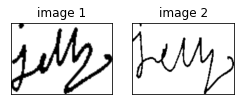

pair   : 3
target : 1


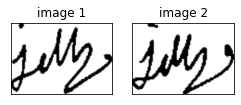

pair   : 4
target : 1


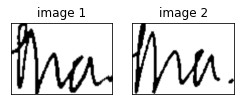

pair   : 5
target : 1


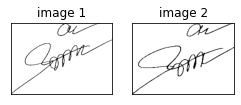

pair   : 6
target : 0


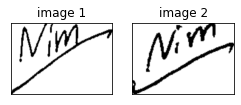

pair   : 7
target : 0


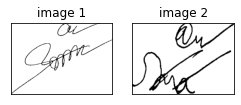

pair   : 8
target : 1


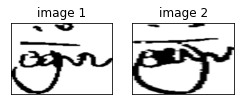

pair   : 9
target : 1


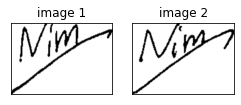

pair   : 10
target : 0


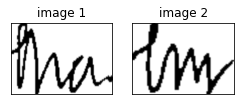

In [ ]:
#@title Visualize verification tasks

trials = 5 #@param {type:"slider", min:5, max:10, step:1}
subset = "train" #@param ["train", "val", "test"]

pairs, targets = my_loader.make_verification_tasks(trials, subset=subset)
show_pairs(pairs, targets)

## show one-shot task

In [ ]:
#@title Define show one-shot task function
def show_oneshot_task(pairs, img_per_row=5,figsize=(10,10)):
    n, h, w, ch = pairs[0].shape

    print('test image:')
    fig,ax = plt.subplots(1, figsize=(3,3))
    ax.get_yaxis().set_visible(False)
    ax.get_xaxis().set_visible(False)
    _ = ax.imshow(pairs[0][0].reshape(h, w), cmap='gray')
    plt.show()
        
    # show all support set (with index 0 expected to be of the same category)
    print('support set:')
    for i in range(int(np.ceil(n/img_per_row)*img_per_row)):
        if i%img_per_row==0: 
            fig, axs = plt.subplots(1, img_per_row, figsize=figsize)
        
        axs[i%img_per_row].get_yaxis().set_visible(False)
        axs[i%img_per_row].get_xaxis().set_visible(False)
        if i < n:
            _ = axs[i%img_per_row].imshow(pairs[1][i].reshape(h, w), cmap='gray')
        else:
            _ = axs[i%img_per_row].imshow(np.zeros((h, w)), cmap='gray')

In [ ]:
#@title Generate one-shot tasks

way = 12 #@param {type:"slider", min:5, max:15, step:1}
subset = "test" #@param ["train", "val", "test"]
tasks = my_loader.make_recognition_tasks(way, 50, subset, shuffle_pairs=True)

test image:


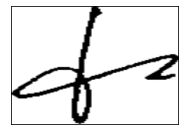

support set:


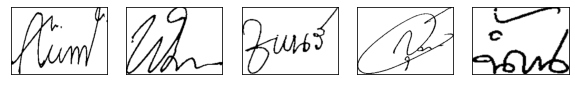

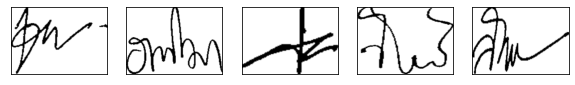

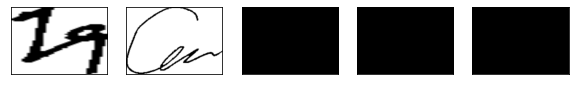

In [ ]:
#@title Visualize one-shot task

task_number = 40 #@param {type:"slider", min:1, max:50, step:1}
pairs, targets = tasks[task_number-1]
show_oneshot_task(pairs)

# Build the model

## Siamese Network

In [ ]:
def initialize_weights(shape, dtype=None):
  return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype=None):
  return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [ ]:
def get_siamese_model(input_shape):
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv2D(64, (10,10), activation='relu', input_shape=input_shape, 
                     kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (7,7), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(128, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling2D())
    model.add(Conv2D(256, (4,4), activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(512, activation='sigmoid', kernel_regularizer=l2(1e-3), 
                    kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [ ]:
siamese_model = get_siamese_model((img_height, img_width, 1))
siamese_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 input_2 (InputLayer)           [(None, 155, 220, 1  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 512)          32652608    ['input_1[0][0]',                
                                                                  'input_2[0][0]']            

In [ ]:
optimizer = Adam(learning_rate = 0.00006)
siamese_model.compile(loss="binary_crossentropy",optimizer=optimizer)

## SigNet

In [ ]:
def euclidean_distance(vects):
    '''Compute Euclidean Distance between two vectors'''
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    return K.mean(y_true * K.square(y_pred) + (1 - y_true) * K.square(K.maximum(margin - y_pred, 0)))

In [ ]:
def create_base_network_signet(input_shape):
    '''Base Siamese Network'''
    
    seq = Sequential()
    seq.add(Conv2D(96, kernel_size=(11, 11), activation='relu', name='conv1_1', strides=4, input_shape= input_shape, 
                        kernel_initializer='glorot_uniform', data_format="channels_last"))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))    
    seq.add(ZeroPadding2D((2, 2), data_format="channels_last"))
    
    seq.add(Conv2D(256, kernel_size=(5, 5), activation='relu', name='conv2_1', strides=1, kernel_initializer='glorot_uniform', data_format="channels_last"))
    seq.add(BatchNormalization(epsilon=1e-06, axis=1, momentum=0.9))
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(ZeroPadding2D((1, 1), data_format="channels_last"))
    
    seq.add(Conv2D(384, kernel_size=(3, 3), activation='relu', name='conv3_1', strides=1, kernel_initializer='glorot_uniform', data_format="channels_last"))
    seq.add(ZeroPadding2D((1, 1), data_format="channels_last"))
    
    seq.add(Conv2D(256, kernel_size=(3, 3), activation='relu', name='conv3_2', strides=1, kernel_initializer='glorot_uniform', data_format="channels_last"))    
    seq.add(MaxPooling2D((3,3), strides=(2, 2)))
    seq.add(Dropout(0.3))# added extra
    seq.add(Flatten(name='flatten'))
    seq.add(Dense(1024, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform'))
    seq.add(Dropout(0.5))
    
    seq.add(Dense(128, kernel_regularizer=l2(0.0005), activation='relu', kernel_initializer='glorot_uniform')) # softmax changed to relu
    
    return seq

In [ ]:
# network definition
input_shape = (img_height, img_width, 1)
base_network = create_base_network_signet(input_shape)

input_a = Input(shape=(input_shape))
input_b = Input(shape=(input_shape))

# because we re-use the same instance `base_network`,
# the weights of the network
# will be shared across the two branches
processed_a = base_network(input_a)
processed_b = base_network(input_b)

# Compute the Euclidean distance between the two vectors in the latent space
distance = Lambda(euclidean_distance, output_shape=eucl_dist_output_shape)([processed_a, processed_b])

signet_model = Model(inputs=[input_a, input_b], outputs=distance)

In [ ]:
# compile model using RMSProp Optimizer and Contrastive loss function defined above
rms = RMSprop(learning_rate=1e-4, rho=0.9, epsilon=1e-08)
signet_model.compile(loss=contrastive_loss, optimizer=rms)

# Train the model

In [ ]:
# Hyper parameters
batch_size = 32
n_iter = 5000
evaluate_every = 100
val_batch_size = 8
n_val = 250

## Siamese Network

In [ ]:
siamese_model_dir = '/content/weights/siamese'
pathlib.Path(siamese_model_dir).mkdir(parents = True, exist_ok = True)

siamese_callbacks = [
    EarlyStopping(patience=7, verbose=1),
    ModelCheckpoint(siamese_model_dir+'/weights_sm_{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
siamese_results = siamese_model.fit(my_loader.generate(batch_size=batch_size),
                                    steps_per_epoch = evaluate_every,
                                    epochs = n_iter//evaluate_every,
                                    validation_data = my_loader.generate(batch_size=val_batch_size, subset="val"),
                                    validation_steps = n_val,
                                    callbacks = siamese_callbacks)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 2.8218
Epoch 1: saving model to /content/weights/siamese/weights_sm_001.h5
100/100 [==============================] - 41s 303ms/step - loss: 2.8218 - val_loss: 2.3183
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.9197
Epoch 2: saving model to /content/weights/siamese/weights_sm_002.h5
100/100 [==============================] - 30s 302ms/step - loss: 1.9197 - val_loss: 1.8398
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 1.4935
Epoch 3: saving model to /content/weights/siamese/weights_sm_003.h5
100/100 [==============================] - 30s 306ms/step - loss: 1.4935 - val_loss: 1.5518
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 1.2134
Epoch 4: saving model to /content/weights/siamese/weights_sm_004.h5
100/100 [==============================] - 30s 302ms/step - loss: 1.2134 - val_loss: 1.3775
Epoch 5/50
100/100 [==============================] 

## SigNet

In [ ]:
signet_model_dir = '/content/weights/signet'
pathlib.Path(signet_model_dir).mkdir(parents = True, exist_ok = True)

signet_callbacks = [
    EarlyStopping(patience=12, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.000001, verbose=1),
    ModelCheckpoint(signet_model_dir+'/weights_sn_{epoch:03d}.h5', verbose=1, save_weights_only=True)
]

In [ ]:
signet_results = signet_model.fit(my_loader.generate(batch_size=batch_size),
                                  steps_per_epoch = evaluate_every,
                                  epochs = n_iter//evaluate_every,
                                  validation_data = my_loader.generate(batch_size=val_batch_size, subset="val"),
                                  validation_steps = n_val,
                                  callbacks = signet_callbacks)

Epoch 1/50
100/100 [==============================] - ETA: 0s - loss: 3.7601
Epoch 1: saving model to /content/weights/signet/weights_sn_001.h5
100/100 [==============================] - 13s 108ms/step - loss: 3.7601 - val_loss: 1.3446 - lr: 1.0000e-04
Epoch 2/50
100/100 [==============================] - ETA: 0s - loss: 1.0648
Epoch 2: saving model to /content/weights/signet/weights_sn_002.h5
100/100 [==============================] - 8s 81ms/step - loss: 1.0648 - val_loss: 1.1522 - lr: 1.0000e-04
Epoch 3/50
100/100 [==============================] - ETA: 0s - loss: 0.7977
Epoch 3: saving model to /content/weights/signet/weights_sn_003.h5
100/100 [==============================] - 8s 81ms/step - loss: 0.7977 - val_loss: 0.9056 - lr: 1.0000e-04
Epoch 4/50
100/100 [==============================] - ETA: 0s - loss: 0.5936
Epoch 4: saving model to /content/weights/signet/weights_sn_004.h5
100/100 [==============================] - 8s 81ms/step - loss: 0.5936 - val_loss: 0.7611 - lr: 1.000

## Visualize training results and Load best weight

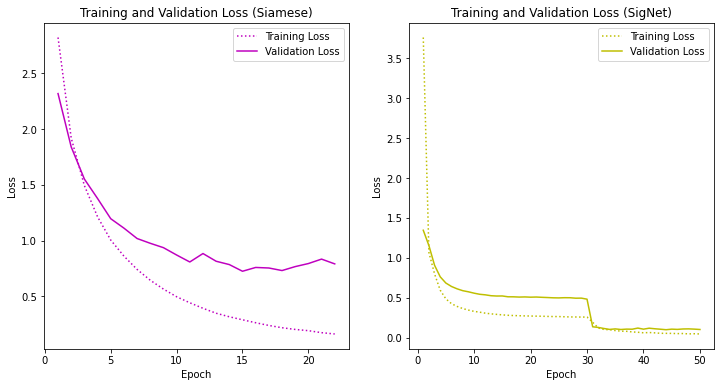

In [ ]:
#@title Visualize training results
siamese_loss = siamese_results.history['loss']
siamese_val_loss = siamese_results.history['val_loss']
siamese_epochs_range = range(1, len(siamese_loss)+1)

signet_loss = signet_results.history['loss']
signet_val_loss = signet_results.history['val_loss']
signet_epochs_range = range(1, len(signet_loss)+1)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(siamese_epochs_range, siamese_loss, ':m',label='Training Loss')
plt.plot(siamese_epochs_range, siamese_val_loss, 'm', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Training and Validation Loss (Siamese)')

plt.subplot(1, 2, 2)
plt.plot(signet_epochs_range, signet_loss, ':y', label='Training Loss')
plt.plot(signet_epochs_range, signet_val_loss, 'y', label='Validation Loss')
plt.legend(loc='upper right')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title('Training and Validation Loss (SigNet)')
plt.show()

In [ ]:
#@title Load best weights

def get_best_weights_file(weight_dir, results):
    weights_list = os.listdir(weight_dir)
    weights_list.sort()

    best_idx = np.argmin(results.history['val_loss'])
    best_weights_file = weights_list[best_idx]
    return best_weights_file

best_siamese_weights_file = get_best_weights_file(siamese_model_dir, siamese_results)
print(f'loading {best_siamese_weights_file} for Siamese Network')
siamese_model.load_weights(os.path.join(siamese_model_dir, best_siamese_weights_file))

best_signet_weights_file = get_best_weights_file(signet_model_dir, signet_results)
print(f'loading {best_signet_weights_file} for SigNet')
signet_model.load_weights(os.path.join(signet_model_dir, best_signet_weights_file))

loading weights_sm_015.h5 for Siamese Network
loading weights_sn_044.h5 for SigNet


# Evaluate the trained model

## Evaluate Recognition Performances

In [ ]:
#@title Define test recognition function

def test_recognition_tasks(tasks, model, ways, measurement='similarity'):
    n_tasks = len(tasks)
    accs = []
    scores = []

    for i in range(n_tasks):
        inputs, targets = tasks[i]
        scores.append(model.predict(inputs))

    scores = np.array(scores)
    for way in ways:
        if measurement=='difference':
            probs = np.exp(-scores) / np.sum(np.exp(-scores))
        elif measurement=='similarity':
            probs = np.exp(scores) / np.sum(np.exp(scores))
        
        target_pred = np.argmax(probs.reshape(n_tasks, ways[-1])[:,:way], axis=1).reshape(-1)
        n_correct = np.sum(np.where(target_pred == 0, 1, 0))
        percent_correct = (100.0*n_correct / n_tasks)
        accs.append(percent_correct)
    return accs

In [ ]:
#@title Testing Recognition Performances
max_way = 30
ways = np.arange(1, max_way+1)

val_rec_tasks = my_loader.make_recognition_tasks(max_way, 250, subset="val")
siamese_val_rec_accs = test_recognition_tasks(val_rec_tasks, siamese_model, ways)
signet_val_rec_accs = test_recognition_tasks(val_rec_tasks, signet_model, ways, measurement='difference')
del val_rec_tasks

test_rec_tasks = my_loader.make_recognition_tasks(max_way, 500, subset="test")
siamese_test_rec_accs = test_recognition_tasks(test_rec_tasks, siamese_model, ways)
signet_test_rec_accs = test_recognition_tasks(test_rec_tasks, signet_model, ways, measurement='difference')
del test_rec_tasks

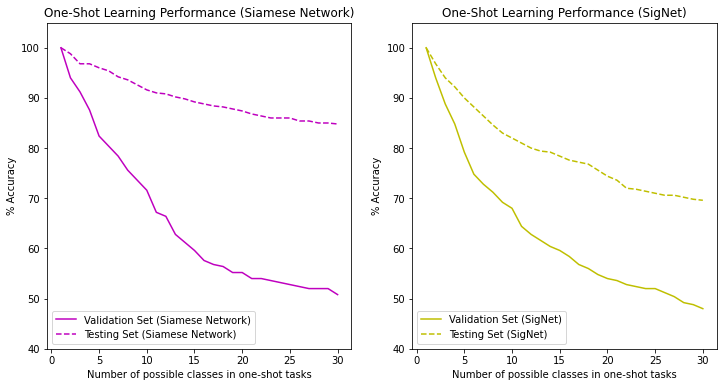

In [ ]:
#@title Visualize Recognition Performances
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(ways, siamese_val_rec_accs, 'm', label='Validation Set (Siamese Network)')
plt.plot(ways, siamese_test_rec_accs, '--m', label='Testing Set (Siamese Network)')
plt.legend(loc='lower left')
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.ylim(40,105)
plt.title('One-Shot Learning Performance (Siamese Network)')

plt.subplot(1, 2, 2)
plt.plot(ways, signet_val_rec_accs, 'y', label='Validation Set (SigNet)')
plt.plot(ways, signet_test_rec_accs, '--y', label='Testing Set (SigNet)')
plt.legend(loc='lower left')
plt.xlabel("Number of possible classes in one-shot tasks")
plt.ylabel("% Accuracy")
plt.ylim(40,105)
plt.title('One-Shot Learning Performance (SigNet)')
plt.show()

## Evaluate Verification Performances

In [ ]:
#@title Define test verification function
def test_verification_tasks(tasks, model, thresholds, measurement='similarity'):
    inputs, targets = tasks
    scores = model.predict(inputs)

    accs = []
    for threshold in thresholds:
        if measurement=='difference':
            target_pred = np.where(scores < threshold, 1, 0).reshape(-1)
        elif measurement=='similarity':
            target_pred = np.where(scores > threshold, 1, 0).reshape(-1)
        
        n_correct = np.sum(np.where(target_pred == targets, 1, 0))
        percent_correct = (100.0*n_correct / len(targets))
        accs.append(percent_correct)
    return accs

In [ ]:
#@title Testing Verification Performances
thresholds = np.arange(0, 1.01, 0.025)

val_ver_tasks = my_loader.make_verification_tasks(250, subset='val')
siamese_val_ver_accs = test_verification_tasks(val_ver_tasks, siamese_model, thresholds)
signet_val_ver_accs = test_verification_tasks(val_ver_tasks, signet_model, thresholds, measurement='difference')
del val_ver_tasks

test_ver_tasks = my_loader.make_verification_tasks(500, subset='test')
siamese_test_ver_accs = test_verification_tasks(test_ver_tasks, siamese_model, thresholds)
signet_test_ver_accs = test_verification_tasks(test_ver_tasks, signet_model, thresholds, measurement='difference')
del test_ver_tasks

32/32 [==============================] - 1s 24ms/step


In [ ]:
#@title Verification Performance Info
class Verification_Performance_Info:
    def __init__(self):
        self.best_threhold_dict = {}
        self.best_accuracy_dict = {}

    def update_info(self, thresholds, ver_accs, label):
        best_threhold_dict = {label: thresholds[np.argmax(ver_accs)]}
        best_accuracy_dict = {label: np.max(ver_accs)}
        
        self.best_threhold_dict.update(best_threhold_dict)
        self.best_accuracy_dict.update(best_accuracy_dict)
    
    def get_info(self):
        return pd.DataFrame({'Best threhold': pd.Series(self.best_threhold_dict),
                             'Best accuracy': pd.Series(self.best_accuracy_dict)})

ver_info = Verification_Performance_Info()
ver_info.update_info(thresholds, siamese_val_ver_accs, 'Validation Set (Siamese Network)')
ver_info.update_info(thresholds, siamese_test_ver_accs, 'Testing Set (Siamese Network)')
ver_info.update_info(thresholds, signet_val_ver_accs, 'Validation Set (SigNet)')
ver_info.update_info(thresholds, signet_test_ver_accs, 'Testing Set (SigNet)')

                                  Best threhold  Best accuracy
Validation Set (Siamese Network)          0.300           69.2
Testing Set (Siamese Network)             0.425           82.4
Validation Set (SigNet)                   0.325           72.0
Testing Set (SigNet)                      0.325           82.2



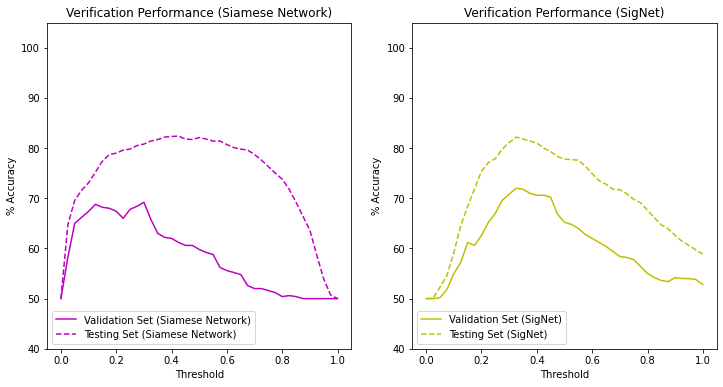

In [ ]:
#@title Visualize Verification Performances
print(ver_info.get_info(), end='\n'*2)

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(thresholds, siamese_val_ver_accs, 'm', label='Validation Set (Siamese Network)')
plt.plot(thresholds, siamese_test_ver_accs, '--m', label='Testing Set (Siamese Network)')
plt.legend(loc='lower left')
plt.xlabel("Threshold")
plt.ylabel("% Accuracy")
plt.ylim(40,105)
plt.title("Verification Performance (Siamese Network)")

plt.subplot(1, 2, 2)
plt.plot(thresholds, signet_val_ver_accs, 'y', label='Validation Set (SigNet)')
plt.plot(thresholds, signet_test_ver_accs, '--y', label='Testing Set (SigNet)')
plt.legend(loc='lower left')
plt.xlabel("Threshold")
plt.ylabel("% Accuracy")
plt.ylim(40,105)
plt.title("Verification Performance (SigNet)")
plt.show()